# Load saved model

In [388]:
#Skip this cell if running for the first time
#if not, directly go to the last cell to predict on random images by replacing "output = face_mask_detector_cnn(inputs)"
#with "output = modelTrained(inputs)"

import os
import torch
if os.path.exists('/FinalModelFDCNN.pkl'):
    modelTrained = torch.load('/FinalModelFDCNN.pkl')
else:
    print("No model saved")



No model saved


# Data Extraction

In [389]:
from tqdm import tqdm
from pathlib import Path
import pandas as pd

#importing dataset
datasetPath = Path('dataset')
no_mask_path = datasetPath/'No-Mask'
cloth_mask_path = datasetPath/'Cloth'
N95_mask_path = datasetPath/'N95'
surgical_mask_path = datasetPath/'Surgical'
N95_with_valve = datasetPath/'N95-with-valve'
mask_DF = pd.DataFrame()

# iterating over the images of no-mask and assigning to each image a label of 0
for imgPath in tqdm(list(no_mask_path.iterdir()), desc='No-Mask'):
    mask_DF = mask_DF.append({
        'image': str(imgPath),
        'mask': 0
    }, ignore_index=True)

# iterating over the images of Cloth mask and assigning to each image a label of 1
for imgPath in tqdm(list(cloth_mask_path.iterdir()), desc='Cloth'):
    mask_DF = mask_DF.append({
        'image': str(imgPath),
        'mask': 1
    }, ignore_index=True)

# iterating over the images of N95 and assigning to each image a label of 2
for imgPath in tqdm(list(N95_mask_path.iterdir()), desc='N95'):
    mask_DF = mask_DF.append({
        'image': str(imgPath),
        'mask': 2
    }, ignore_index=True)

# iterating over the images of Surgical and assigning to each image a label of 3
for imgPath in tqdm(list(surgical_mask_path.iterdir()), desc='Surgical'):
    mask_DF = mask_DF.append({
        'image': str(imgPath),
        'mask': 3
    }, ignore_index=True)

# iterating over the images of N95 mask with valve and assigning to each image a label of 4
for imgPath in tqdm(list(N95_with_valve.iterdir()), desc='N95-with-valve'):
    mask_DF = mask_DF.append({
        'image': str(imgPath),
        'mask': 4
    }, ignore_index=True)

# store the dataset into a file using pickle[serialise]
dataframe_name = 'dataset/dataset.pickle'
print(f'Saving Dataframe to: {dataframe_name}')
mask_DF.to_pickle(dataframe_name)
print(dataframe_name)



N95-with-valve: 100%|███████████████████████| 540/540 [00:00<00:00, 1323.68it/s]

Saving Dataframe to: dataset/dataset.pickle
dataset/dataset.pickle


### Building Dataset Class

In [390]:
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

#Creating a dataset class for querying samples by batches so that it can be interpretable by pytorch
#Transforming the given image into 32x32 and converting it to a tensor

class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.3082, 0.2988, 0.3053))
        ])

    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('Slicing is supported')

        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }

    def __len__(self):
        return len(self.dataFrame.index)





# Building Face detection model

### Defining the model and the forward pass

In [391]:
import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torchsummary import summary
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential, functional)

# defining model architecture along with forward pass
# Using ReLU as an activation function - it will output the input directly if it is positive, otherwise, it will output zero
# Reason for using ReLU is because it is simple, fast, and empirically it seems to work well.
# using MaxPool2d as the pooling layer - calculates the maximum, or largest, value in each patch of each feature map

class FaceMaskDetectorCNN(nn.Module):
    def __init__(self):
        super(FaceMaskDetectorCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 5)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

face_mask_detector_cnn = FaceMaskDetectorCNN()
print(summary(face_mask_detector_cnn,input_size = (3,32,32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
        LeakyReLU-13           [-1, 64, 16, 16]               0
        MaxPool2d-14             [-1, 6

### Confusion matrix

In [392]:
from pathlib import Path
from typing import Dict, List, Union
import pandas as pd
import torch
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt

def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')



### Preparing the data for the model

In [393]:
# splitting the data using k-fold into train_folds and validate_folds
def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        print(mask_df['mask'].value_counts())
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        train_folds = []
        validate_folds = []
        for train_index, validate_index in skf.split(mask_df, mask_df['mask']):
            train_folds.append(MaskDetectionDataset(mask_df.iloc[train_index]))
            validate_folds.append(MaskDetectionDataset(mask_df.iloc[validate_index]))
        return [
            train_folds, validate_folds,CrossEntropyLoss()
            ]


### Data loaders

In [394]:
# data loader that will be used for training and validation
# using num_workers = 0 which means that the main process will do that data loading when needed
#[num_workers is basically the number of multi-sub processes to load data, if it is 0 it means that RAM remains stable with the increase of epoch]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)

train_dfs, validate_dfs, cross_entropy_loss = prepare_data("dataset/dataset.pickle")



0.0    667
4.0    540
2.0    524
1.0    510
3.0    508
Name: mask, dtype: int64


### Training model

In [395]:
# fixing the learning rate as 0.001
epochs = 10
learning_rate = 0.001
retrain = False

import warnings
warnings.filterwarnings('ignore')

# Overriding the optimizer and returning the desired optimizer
#using Adam for the overriding purpose
# we received the batch of sample and pass through the face_mask_detector_cnn via forward pass [defined in the face_mask_detector_cnn] and compute the loss of the batch
# printing the loss log according to the requirement.

def train_model(train_fold):
    acc_list = []
    loss_list = []
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        total=0
        correct=0
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_fold), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #training accuracy
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_train += loss
        print('Training Loss after epoch {} : {}, Correction prediction : {} / {} Accuracy: {:.2f}%'.format(epoch, loss_train, correct, total ,(correct / total) * 100))


# Model Evaluation

In [396]:
from numpy import vstack
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# evaluating our model on validation set
def evaluate_model(validate_fold):
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(validate_fold)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)

    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))


Running Fold : 1
Training Loss after epoch 0 : 74.09729766845703, Correction prediction : 1571 / 2474 Accuracy: 63.50%
Training Loss after epoch 1 : 42.92781448364258, Correction prediction : 1967 / 2474 Accuracy: 79.51%
Training Loss after epoch 2 : 36.0922737121582, Correction prediction : 2048 / 2474 Accuracy: 82.78%
Training Loss after epoch 3 : 26.705156326293945, Correction prediction : 2152 / 2474 Accuracy: 86.98%
Training Loss after epoch 4 : 23.072036743164062, Correction prediction : 2209 / 2474 Accuracy: 89.29%
Training Loss after epoch 5 : 16.676681518554688, Correction prediction : 2280 / 2474 Accuracy: 92.16%
Training Loss after epoch 6 : 11.939430236816406, Correction prediction : 2330 / 2474 Accuracy: 94.18%
Training Loss after epoch 7 : 8.2379150390625, Correction prediction : 2381 / 2474 Accuracy: 96.24%
Training Loss after epoch 8 : 8.302173614501953, Correction prediction : 2387 / 2474 Accuracy: 96.48%
Training Loss after epoch 9 : 7.59243106842041, Correction predi

Training Loss after epoch 9 : 5.681445121765137, Correction prediction : 2420 / 2474 Accuracy: 97.82%
Running Fold : 9
Training Loss after epoch 0 : 78.77871704101562, Correction prediction : 1525 / 2474 Accuracy: 61.64%
Training Loss after epoch 1 : 45.943931579589844, Correction prediction : 1930 / 2474 Accuracy: 78.01%
Training Loss after epoch 2 : 35.85686492919922, Correction prediction : 2058 / 2474 Accuracy: 83.19%
Training Loss after epoch 3 : 28.99622344970703, Correction prediction : 2138 / 2474 Accuracy: 86.42%
Training Loss after epoch 4 : 20.82742691040039, Correction prediction : 2235 / 2474 Accuracy: 90.34%
Training Loss after epoch 5 : 18.630565643310547, Correction prediction : 2253 / 2474 Accuracy: 91.07%
Training Loss after epoch 6 : 15.009398460388184, Correction prediction : 2299 / 2474 Accuracy: 92.93%
Training Loss after epoch 7 : 10.49638557434082, Correction prediction : 2361 / 2474 Accuracy: 95.43%
Training Loss after epoch 8 : 9.49242877960205, Correction pre

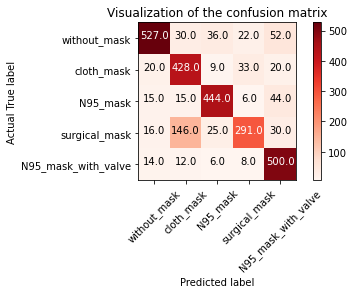

In [397]:
# Running 10 folds with 10 epochs each
# computing the confusion matrix, accuracy score, precision recall and fscore

fold_results = []
fold_confusion_matrix = np.zeros((5,5))
classes = ['without_mask', 'cloth_mask', 'N95_mask', 'surgical_mask','N95_mask_with_valve']

for fold_index in range(len(train_dfs)):
    print("Running Fold : "+ str(fold_index+1))
    train_model(train_dfs[fold_index])
    fold_result = evaluate_model(validate_dfs[fold_index])
    #conf_mat, acc, pre, recall, f-score
    fold_results.append(fold_result[1:-1])
    fold_confusion_matrix = np.add(fold_confusion_matrix,fold_result[0])
    if fold_index != len(train_dfs)-1:
        face_mask_detector_cnn = FaceMaskDetectorCNN()

metrics_df = pd.DataFrame(fold_results, columns=['accuracy', 'precision', 'recall', 'f-score'])
print()
print("Metrics")
print(metrics_df.mean())
print()
print("Across 10-folds")
plot_cm(fold_confusion_matrix, classes)


### Testing our model on random dataset

N95-with-valve: 100%|████████████████████████████| 2/2 [00:00<00:00, 674.54it/s]


testDataset/random/File 25.jpg
Predicted: N95-with-valve


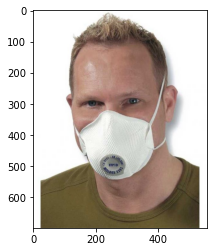

In [404]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "cloth_mask",
    2: "N95 Mask",
    3: "surgical_mask",
    4: "N95-with-valve"
}

def prepare_predict_df():
    testDatasetPath = Path('testDataset')
    testRandomMaskPath = testDatasetPath/'random'
    testDF = pd.DataFrame()

    for imgPath in tqdm(list(testRandomMaskPath.iterdir()), desc='No-Mask'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 0
        }, ignore_index=True)

    for imgPath in tqdm(list(testRandomMaskPath.iterdir()), desc='Cloth'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 1
        }, ignore_index=True)

    for imgPath in tqdm(list(testRandomMaskPath.iterdir()), desc='N95'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 2
        }, ignore_index=True)

    for imgPath in tqdm(list(testRandomMaskPath.iterdir()), desc='Surgical'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 3
        }, ignore_index=True)
    for imgPath in tqdm(list(testRandomMaskPath.iterdir()), desc='N95-with-valve'):
        testDF = testDF.append({
            'image': str(imgPath),
            'mask': 4
    }, ignore_index=True)

    return MaskDetectionDataset(testDF)

def predict():
    test_df = prepare_predict_df()
    rand_sampler = torch.utils.data.RandomSampler(test_df, num_samples=32, replacement=True)
    data = iter(DataLoader(test_df, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    output = face_mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    rand_ind = random.choice(list(range(0,32)))
    print(data['path'][rand_ind])
    img = Image.open(data['path'][rand_ind])
    plt.imshow(np.asarray(img))
    print("Predicted:",class_mapping[output[rand_ind].tolist()])

predict()

### Saving the model

In [401]:
torch.save(face_mask_detector_cnn, 'FinalModelFDCNN.pkl')
